In [1]:
import numpy as np
from scipy.misc import imresize
import pylab
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform, filters
import sys, pylab, operator, csv
import os
import urllib

%matplotlib notebook

%load_ext autoreload
%autoreload 2

import caffe

from helpers import *
from heatmaps import *
from optimize_mask import *

In [2]:
gpu = 0
net_type = 'googlenet'

In [3]:
caffe.set_device(gpu)
caffe.set_mode_gpu()

net = get_net(net_type)

# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 224, 224)
conv1/7x7_s2	(10, 64, 112, 112)
pool1/3x3_s2	(10, 64, 56, 56)
pool1/norm1	(10, 64, 56, 56)
conv2/3x3_reduce	(10, 64, 56, 56)
conv2/3x3	(10, 192, 56, 56)
conv2/norm2	(10, 192, 56, 56)
pool2/3x3_s2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_0	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_1	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_3	(10, 192, 28, 28)
inception_3a/1x1	(10, 64, 28, 28)
inception_3a/3x3_reduce	(10, 96, 28, 28)
inception_3a/3x3	(10, 128, 28, 28)
inception_3a/5x5_reduce	(10, 16, 28, 28)
inception_3a/5x5	(10, 32, 28, 28)
inception_3a/pool	(10, 192, 28, 28)
inception_3a/pool_proj	(10, 32, 28, 28)
inception_3a/output	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_0	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_1	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_2	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_spl

In [4]:
labels_desc = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_words.txt', str, delimiter='\t')
(paths, labels) = read_imdb('/home/ruthfong/packages/caffe/data/ilsvrc12/annotated_train_heldout_imdb.txt')
paths = np.array(paths)
labels = np.array(labels)
data_desc = 'train_heldout'

n02097209 standard schnauzer 198
1.0 0.0 (375, 500, 3)


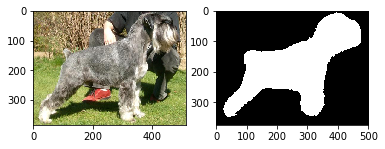

In [112]:
img_path = '/data/ruthfong/ferrari/images/n02097209_2316.jpg'
img = caffe.io.load_image(img_path)
seg = caffe.io.load_image('/data/ruthfong/ferrari/segs/n02097209_2316-v1.png')
transformer = get_ILSVRC_net_transformer(net)
net.blobs['data'].data[...] = transformer.preprocess('data', img)
net.forward()
output = np.squeeze(net.blobs['prob'].data)
sorted_idx = np.argsort(output)
print labels_desc[sorted_idx[-1]], sorted_idx[-1]
print seg.max(), seg.min(), seg.shape
assert(np.array_equal(seg[:,:,0],seg[:,:,1]))
f, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(seg)

187499
0.948
0.0


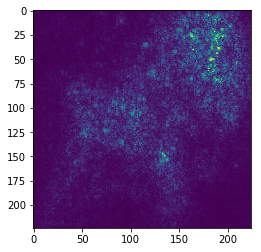

In [114]:
heatmap = compute_heatmap(net, get_ILSVRC_net_transformer(net), img_path, 198, 'saliency', 'loss3/classifier', 'loss3/classifier', gpu = gpu)
f,ax = plt.subplots(1,1)
ax.imshow(heatmap)
x = seg.mean(2)
heatmap_r = imresize(heatmap, x.shape)
sorted_hm_idx = np.argsort(heatmap_r, axis=None)
print sorted_hm_idx.max()
y = x.flatten()
print y[sorted_hm_idx[-1000:]].mean()
print y[sorted_hm_idx[:1000]].mean()
#x[sorted_hm_idx]

<IPython.core.display.Javascript object>


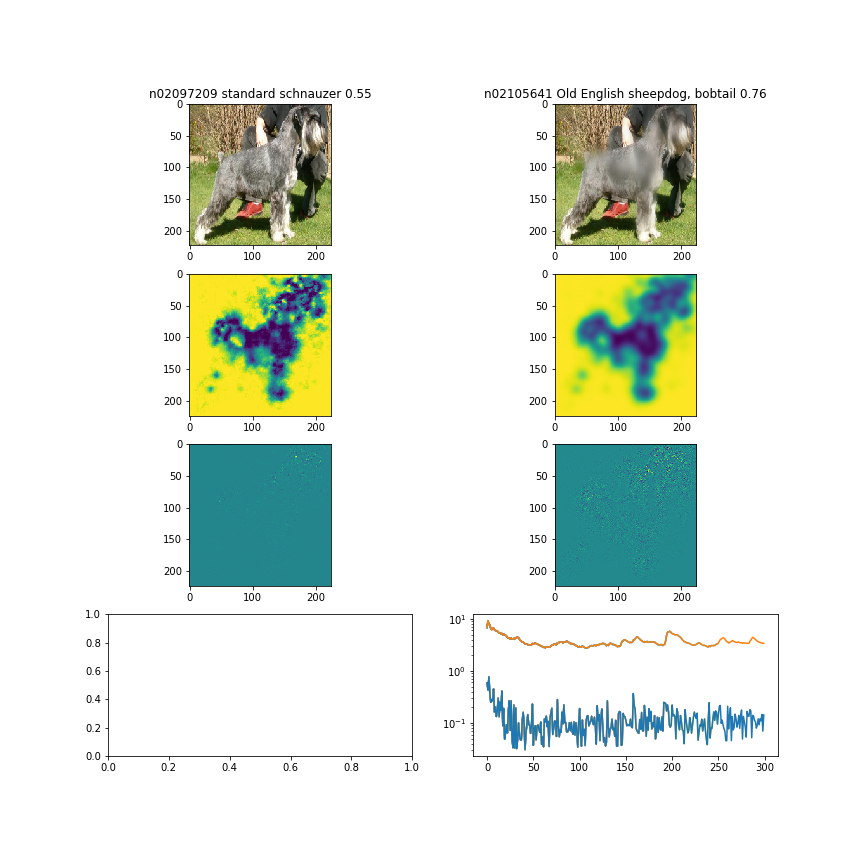

<IPython.core.display.Javascript object>


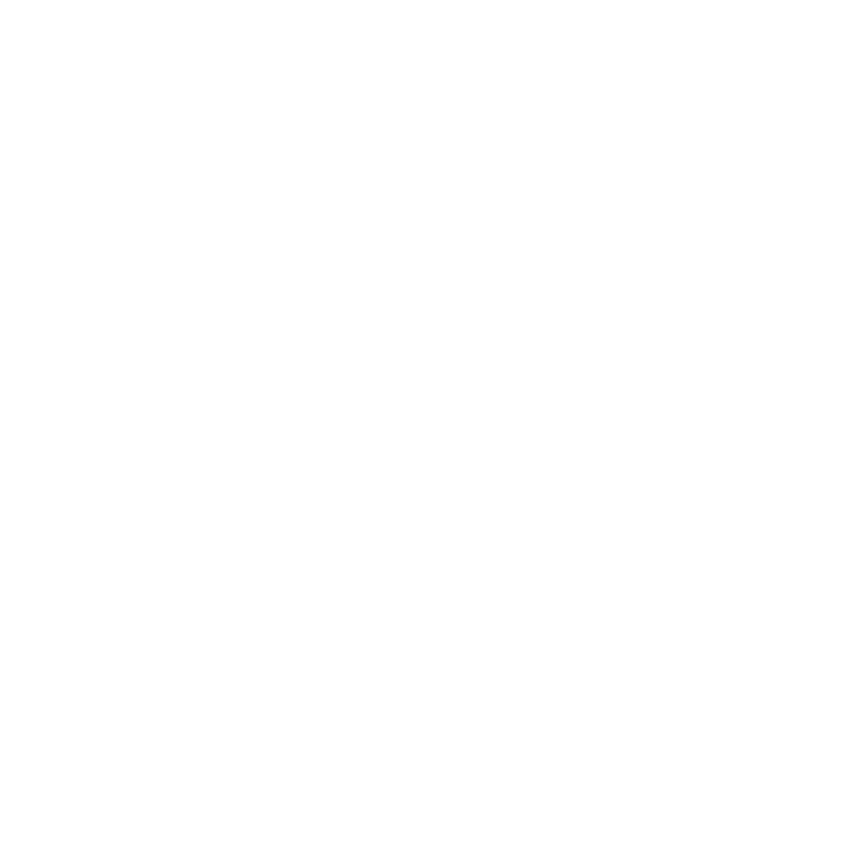

In [129]:
%matplotlib notebook

data_desc = 'ferrari'

num_iters = 300
lr = 1e-1
l1_lambda = 1e-4
l1_ideal = 1
l1_lambda_2 = 0
tv_lambda = 1e-2
tv_beta = 2
jitter = 4
num_top = 5
noise = 0
null_type = 'blur'
given_gradient = True
norm_score = False
end_layer = 'prob'
use_conv_norm = False
blur_mask = 5
mask_scale = 1

path = img_path
i = 'n02097209_2316'
label = 198

net = get_net(net_type)
net_transformer = get_ILSVRC_net_transformer(net)

img = net_transformer.preprocess('data', caffe.io.load_image(path))
net.blobs['data'].data[...] = img
net.forward()
scores = np.squeeze(net.blobs['prob'].data)
sorted_idx = np.argsort(scores)
if given_gradient:
    target = np.zeros(scores.shape)
    if num_top == 0:
        target[label] = 1
    else:
        target[sorted_idx[:-(num_top+1):-1]] = 1
else:
    if num_top == 0:
        target = np.array([label])
    else:
        target = sorted_idx[:-(num_top+1):-1]

#mask_radius = test_circular_masks(net, path, label, plot = False, end_layer = end_layer, thres = 1e-2)
#mask_init = 1-create_blurred_circular_mask((net.blobs['data'].data.shape[2], net.blobs['data'].data.shape[3]), 
#                                        mask_radius, center = None, sigma = 10)
mask_init = 1-scipy.misc.imresize(seg[:,:,0], (net.blobs['data'].data.shape[2], net.blobs['data'].data.shape[3]))/float(255)
#mask_init = np.zeros((net.blobs['data'].data.shape[2], net.blobs['data'].data.shape[3]))
fig_path = None
mask_path = None
#fig_path = os.path.join('/data/ruthfong/neural_coding/pycaffe_figs/%s_%s_given_grad_%d_norm_simple_%d/min_top%d_prob_%s/lr_%.2f_l1_lambda_%.2f_l1_lambda2_%.2f_tv_lambda_%.2f_beta_%.2f_mask_scale_%d_blur_mask_%d_jitter_%d_noise_%.1f_num_iters_%d_tv2_mask_init/%s.png' % (
#    net_type, data_desc, int(given_gradient), int(norm_score), num_top, null_type, np.log10(lr), np.log10(l1_lambda), np.log10(l1_lambda_2), np.log10(tv_lambda), tv_beta, mask_scale, blur_mask, jitter, np.log10(noise), num_iters, i))
#mask_path = os.path.join('/data/ruthfong/neural_coding/pycaffe_results/%s_%s_given_grad_%d_norm_simple_%d/min_top%d_prob_%s/lr_%.2f_l1_lambda_%.2f_tv_lambda_%.2f_l1_lambda_2_%.2f_beta_%.2f_mask_scale_%d_blur_mask_%d_jitter_%d_noise_%.1f_num_iters_%d_tv2_mask_init/%s.npy' % (
#    net_type, data_desc, int(given_gradient), int(norm_score), num_top, null_type, np.log10(lr), np.log10(l1_lambda), np.log10(l1_lambda_2), np.log10(tv_lambda), tv_beta, mask_scale, blur_mask, jitter, np.log10(noise), num_iters, i))


#if os.path.exists(mask_path):
#   print '%s already exists so skipping' % mask_path
#   continue


x = optimize_mask(net, path, target, labels = labels_desc, given_gradient = given_gradient, norm_score = norm_score,
                    num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, l1_ideal = 1,
                    l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, mask_scale = mask_scale,
                    use_conv_norm= use_conv_norm, blur_mask = blur_mask, jitter = jitter,
                    null_type = null_type, mask_init = mask_init, gpu = gpu, start_layer = None, end_layer = end_layer,
                    plot_step = 50, debug = False, fig_path = fig_path, mask_path = mask_path)

In [117]:
def compute_prc(heatmap, gt_segmentation):
    if len(gt_segmentation.shape) > 2:
        assert(len(gt_segmentation.shape) == 3)
        assert(gt_segmentation.shape[-1] == 3)
        assert(np.array_equal(gt_segmentation[:,:,0], gt_segmentation[:,:,1]) 
               and np.array_equal(gt_segmentation[:,:,0], gt_segmentation[:,:,2]))
        gt_segmentation = gt_segmentation[:,:,0]
    if not np.array_equal(heatmap.shape, gt_segmentation.shape):
        heatmap = scipy.misc.imresize(heatmap, gt_segmentation.shape)/float(255)
    pred = heatmap.flatten()
    gt = gt_segmentation.flatten()
    tp_i = np.zeros(pred.shape)
    tn_i = np.zeros(pred.shape)
    fp_i = np.zeros(pred.shape)
    fn_i = np.zeros(pred.shape)
    tp_idx = np.intersect1d(np.where(pred > 0)[0], np.where(gt == 1)[0])
    tn_idx = np.intersect1d(np.where(pred == 0)[0], np.where(gt == 0)[0])
    fp_idx = np.intersect1d(np.where(pred > 0)[0], np.where(gt == 0)[0])
    fn_idx = np.intersect1d(np.where(pred == 0)[0], np.where(gt == 1)[0])
    assert(len(tp_idx) + len(tn_idx) + len(fp_idx) + len(fn_idx) == len(pred))
    tp_i[tp_idx] = 1
    tn_i[tn_idx] = 1
    fp_i[fp_idx] = 1
    fn_i[fn_idx] = 1
    sorted_i = np.argsort(pred)[::-1] # descending order
    tp_cum = np.cumsum(tp_i[sorted_i])
    tn_cum = np.cumsum(tn_i[sorted_i])
    fp_cum = np.cumsum(fp_i[sorted_i])
    fn_cum = np.cumsum(fn_i[sorted_i])
    precision = np.true_divide(tp_cum, np.array(tp_cum+fp_cum))
    recall = np.true_divide(tp_cum, np.array(tp_cum+fn_cum))
    plt.plot(recall, precision)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()
    plt.plot(precision)
    plt.ylabel('Cum Precision')
    plt.show()
    plt.plot(recall)
    plt.ylabel('Cum Recall')
    plt.show()
    f, ax = plt.subplots(2,2)
    ax[0,0].plot(tp_cum)
    ax[0,0].set_title('Cum TP')
    ax[0,1].plot(tn_cum)
    ax[0,1].set_title('Cum TN')
    ax[1,0].plot(fp_cum)
    ax[1,0].set_title('Cum FP')
    ax[1,1].plot(fn_cum)
    ax[1,1].set_title('Cum FN')
    plt.show()
    return (recall, precision)

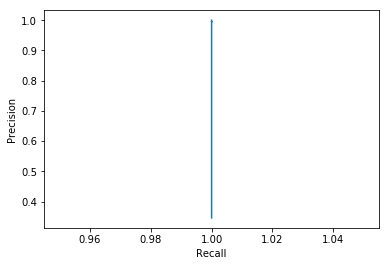

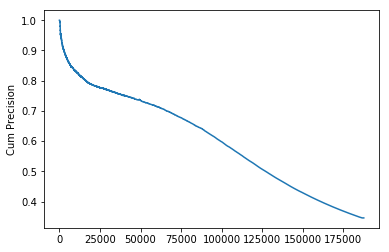

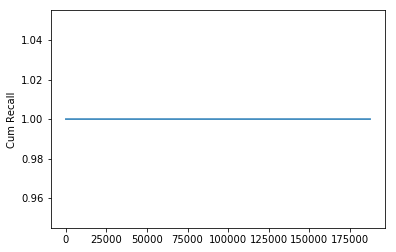

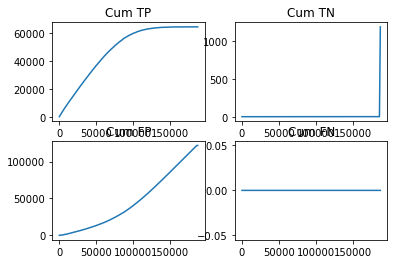

0.603489619881


In [118]:
%matplotlib inline
(recall, precision) = compute_prc(heatmap, seg)
print precision.mean()

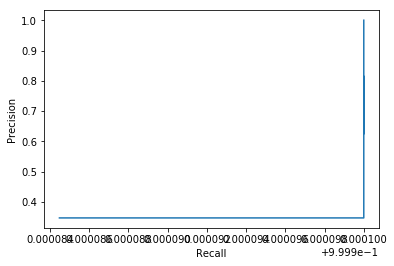

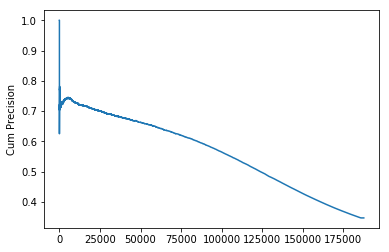

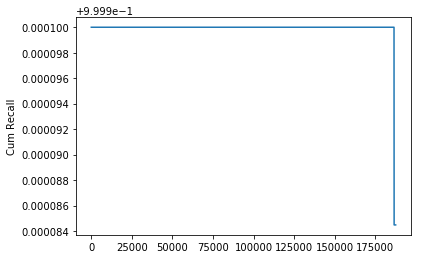

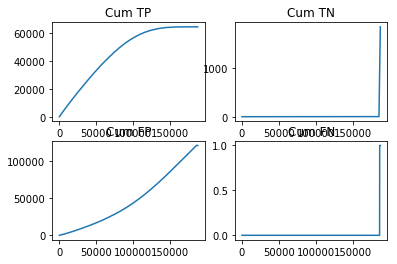

0.560726991712


In [119]:
heatmap_guided = compute_heatmap(net, get_ILSVRC_net_transformer(net), img_path, 165, 'guided_backprop', 'loss3/classifier', 'loss3/classifier', gpu = gpu)
(recall, precision) = compute_prc(heatmap_guided, seg)
print precision.mean()

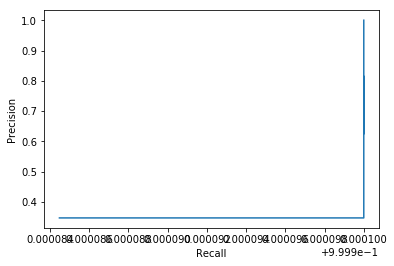

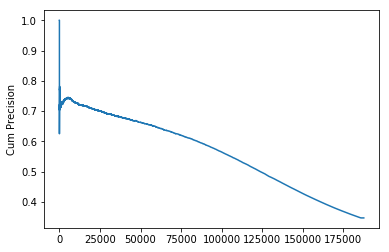

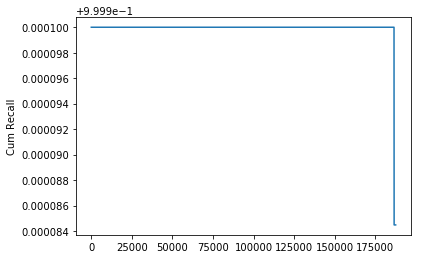

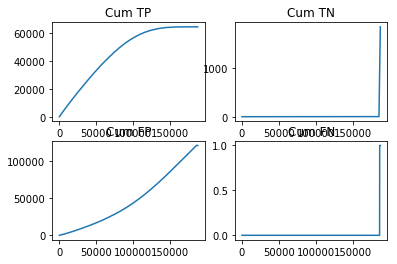

0.560726991712


In [120]:
heatmap_eb = compute_heatmap(net, get_ILSVRC_net_transformer(net), img_path, 165, 'excitation_backprop', 'loss3/classifier', 'loss3/classifier', 
                                 outputBlobName = 'pool2/3x3_s2', outputLayerName = 'pool2/3x3_s2', norm_deg = -1, gpu = gpu)
(recall, precision) = compute_prc(heatmap_guided, seg)
print precision.mean()

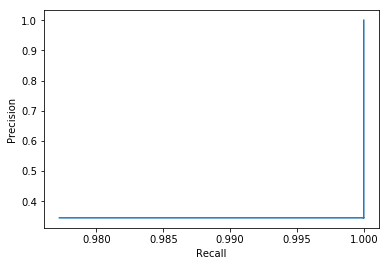

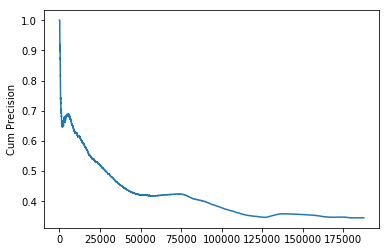

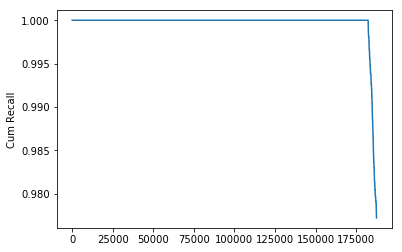

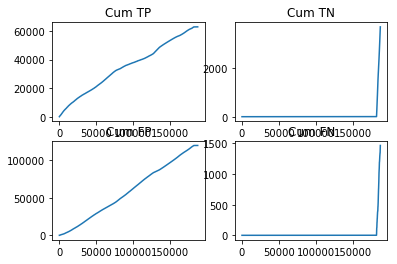

0.418094156313


In [121]:
heatmap_mask = np.load('/data/ruthfong/neural_coding/pycaffe_results/googlenet_ferrari_given_grad_1_norm_simple_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init/n02107142_3870.npy')
heatmap_mask = 1 - heatmap_mask
(recall, precision) = compute_prc(heatmap_mask, seg)
print precision.mean()